To do:
- merge valid and train
- generate new valid: https://www.kaggle.com/anqitu/data-distribution-eda-and-leaderboard-exploit/code
- train linear classifier and compare to MLP performance (drop these features if there is no difference in performance)
- try getting activations from earlier in the network
- transfer learning: adjust later last layers of ResNet50 to our task
- train CNN from scratch: http://cs231n.github.io/transfer-learning/
- check scaling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
import time
from copy import deepcopy

%matplotlib inline 

import os
print(os.listdir("."))

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

['.git', '.gitignore', '.ipynb_checkpoints', 'Classification.ipynb', 'data', 'feature_extractor.py', 'feature_extractor_batch.py', 'feature_extractor_linux.py', 'Initial exploration.ipynb', 'keras_test.py', 'LICENSE', 'mlp_200_100.pkl', 'out.csv', 'README.md', 'rescale.py', 'Silllina.ipynb', 'submission.csv', 'test.csv', 'test.json', 'TF-MLP.ipynb', 'train.json', 'try_this_one.csv', 'validation.json', 'warm_clfs.pkl', 'warm_clfs2.pkl', 'warm_clfs3.pkl', 'warm_clfs4.pkl']


In [2]:
import glob
import pickle

FEATURES_LOCATION = './data/features/'
F_CORE = 'cnn_features_'

def get_label_from_path(file):
    return file.split('\\')[1].split('.')[0]

def load_data(mode):
    if(mode == 'test'):
        pickle_path = F_CORE + mode
        data = pickle.load(open(FEATURES_LOCATION + pickle_path + '.pkl', 'rb'))
        to_return = {}
        for key, value in list(data.items()):
            to_return[get_label_from_path(key)] = value.reshape(1,-1)
        return to_return, None
    
    pickle_path = F_CORE + mode + '_'
    
    data = {}
    for i in range(1,129):
        data[i] = pickle.load(open(FEATURES_LOCATION + pickle_path + str(i) + '.pkl', 'rb'))
        
    X = []
    y = []
    for key, value in list(data.items()):
        the_class = key
        features = np.array(list(value.values()))
        for feature in features:
            y.append(the_class)
            X.append(feature)

    return np.array(X), np.array(y)

In [3]:
X, y = load_data('train')
X_val, y_val = load_data('valid')

716


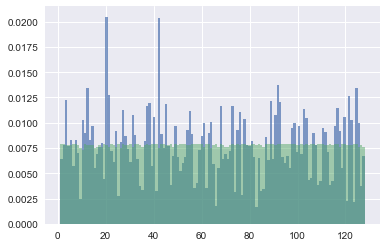

In [11]:
weights = np.ones_like(y) / (len(y))
_ = plt.hist(y, weights=weights, bins=np.max(y), alpha=0.7)
weights = np.ones_like(y_val) / (len(y_val))
_ = plt.hist(y_val, weights=weights, bins=np.max(y_val), alpha=0.5)

from collections import Counter
counted = Counter(y)
most_common_class = counted.most_common()[0][0]
        
print(counted[34])

In [4]:
X = np.concatenate((X, X_val), axis=0)
y = np.concatenate((y, y_val), axis=0)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.05)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=200, alpha=0.25,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate='adaptive', learning_rate_init=.1)
mlp.fit(X_train, y_train)

In [ ]:
from sklearn.externals import joblib
joblib.dump(mlp, 'mlp_200_100.pkl') 

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.1)

warm_mlp = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1, alpha=1e-4,
            solver='sgd', verbose=10, tol=1e-4, random_state=None,
            learning_rate='adaptive', learning_rate_init=.001,
            warm_start=True)

val_scores = []
losses = []
clfs = []
for i in range(1,4000):
    warm_mlp.fit(X_train,y_train)
    val_score = warm_mlp.score(X_val, y_val)
    
    val_scores.append(val_score)
    losses.append(warm_mlp.loss_)
    if(val_score > 0.78):
        clfs.append(deepcopy(warm_mlp))
    
    print("Val score:", val_score)

from sklearn.externals import joblib
joblib.dump(clfs, 'warm_clfs_512.pkl') 

Iteration 1, loss = 2.28873116


C:\Users\Michal\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Val score: 0.6292825473599355
Iteration 2, loss = 1.22757467
Val score: 0.6838976219266425
Iteration 3, loss = 1.05957962
Val score: 0.7043530834340992
Iteration 4, loss = 0.97396514
Val score: 0.7199214026602176
Iteration 5, loss = 0.91685031
Val score: 0.7296453043127771
Iteration 6, loss = 0.87350552
Val score: 0.736446997178557
Iteration 7, loss = 0.83941594
Val score: 0.7438029020556227
Iteration 8, loss = 0.81027740
Val score: 0.748690044336961
Iteration 9, loss = 0.78619717
Val score: 0.7507557436517533
Iteration 10, loss = 0.76378661
Val score: 0.7555925030229746
Iteration 11, loss = 0.74458201
Val score: 0.7582627972591697
Iteration 12, loss = 0.72656728
Val score: 0.7596231358323257
Iteration 13, loss = 0.71045980
Val score: 0.7627468762595727
Iteration 14, loss = 0.69517952
Val score: 0.7653667875856509
Iteration 15, loss = 0.68135815
Val score: 0.7672813381700927
Iteration 16, loss = 0.66855619
Val score: 0.7676844014510278
Iteration 17, loss = 0.65600149
Val score: 0.77005

C:\Users\Michal\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Val score: 0.7939842805320435


KeyboardInterrupt: 

In [13]:
for i in range(1,40):
    warm_mlp.fit(X_train,y_train)
    val_score = warm_mlp.score(X_val, y_val)
    
    val_scores.append(val_score)
    losses.append(warm_mlp.loss_)
    if(val_score > 0.785):
        clfs.append(deepcopy(warm_mlp))
    
    print("Val score:", val_score)

from sklearn.externals import joblib
joblib.dump(clfs, 'warm_clfs4.pkl') 

Iteration 118, loss = 0.16783498
Val score: 0.7964530431277711
Iteration 119, loss = 0.16611181
Val score: 0.7971584038694075
Iteration 120, loss = 0.16396161
Val score: 0.798770656993148
Iteration 121, loss = 0.16225765
Val score: 0.7965538089480049
Iteration 122, loss = 0.16040205
Val score: 0.7970576380491737
Iteration 123, loss = 0.15853175
Val score: 0.7954453849254333
Iteration 124, loss = 0.15677194
Val score: 0.79695687222894
Iteration 125, loss = 0.15485444
Val score: 0.7975614671503426
Iteration 126, loss = 0.15295885
Val score: 0.7977629987908101
Iteration 127, loss = 0.15128176
Val score: 0.7977629987908101
Iteration 128, loss = 0.14951657
Val score: 0.7967553405884724
Iteration 129, loss = 0.14800201
Val score: 0.7959492140266021
Iteration 130, loss = 0.14639875
Val score: 0.7952438532849657
Iteration 131, loss = 0.14457120
Val score: 0.797359935509875
Iteration 132, loss = 0.14293582
Val score: 0.7970576380491737
Iteration 133, loss = 0.14133046
Val score: 0.7972591696896

['warm_clfs4.pkl']

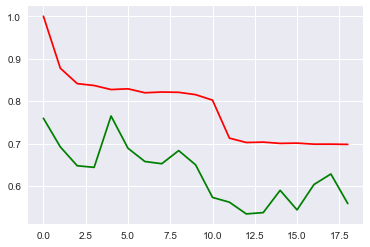

In [44]:
plt.plot(range(len(losses)), 1 - np.array(val_scores), 'g')
plt.plot(range(len(losses)), losses / max(losses), 'r')
plt.show()

In [101]:
X_test, _ = load_data('test')

In [69]:
# ONE PREDICTION AT A TIME
predictions = {}
for index, feature_vector in X_test.items():
    predictions[int(index)] = the_clf.predict(feature_vector)[0]
    print(index, end='\r')

In [108]:
# BATCH OF PREDICTIONS
X_test_arr = np.array(list(X_test.values()))
X_test_arr = X_test_arr.reshape(-1,2048)

y_pred = the_clf.predict(X_test_arr)
predictions2 = {}
for i, index in enumerate(X_test.keys()):
    predictions2[int(index)] = y_pred[i]

In [109]:
prev_pred = deepcopy(predictions)
predictions = predictions2

In [110]:
from collections import Counter
counted = Counter(predictions.values())
most_common_class = counted.most_common()[0][0]

for index in range(1, 12801):
    if(index not in predictions.keys()):
        predictions[index] = most_common_class

In [111]:
ids = []
values = []
for key, value in predictions.items():
    ids.append(key)
    values.append(value)
    
out_dict = {}
out_dict['id'] = ids
out_dict['predicted'] = values

In [113]:
keys = sorted(out_dict.keys())
COL_WIDTH = 6
FMT = "%%-%ds" % COL_WIDTH

with open('try_this_one.csv', 'w') as csv:
    # Write keys    
    csv.write(','.join([k for k in keys]) + '\n')

    # Assume all values of dict are equal
    for i in range(len(out_dict[keys[0]])):
        csv.write(','.join([FMT % out_dict[k][i] for k in keys]) + '\n')

In [27]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.1)
warm_mlp = MLPClassifier(hidden_layer_sizes=(200,), max_iter=1, alpha=1e-4,
            solver='sgd', verbose=10, tol=1e-4, random_state=None,
            learning_rate='adaptive', learning_rate_init=.001,
            warm_start=True)

val_scores = []
losses = []
clfs = []
for i in range(1,4000):
    warm_mlp.fit(X_train,y_train)
    val_score = warm_mlp.score(X_val, y_val)
    
    val_scores.append(val_score)
    losses.append(warm_mlp.loss_)
    if(val_score > 0.7):
        clfs.append(deepcopy(warm_mlp))
    
    print("Val score:", val_score)

from sklearn.externals import joblib
joblib.dump(clfs, 'clfs_250features.pkl') 

Iteration 1, loss = 2.89798529


C:\Users\Michal\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Val score: 0.5282144296654575
Iteration 2, loss = 1.58595645
Val score: 0.609230149133414
Iteration 3, loss = 1.33435703
Val score: 0.6424324869004434
Iteration 4, loss = 1.21493818
Val score: 0.6618802902055623
Iteration 5, loss = 1.14020006
Val score: 0.673720274083031
Iteration 6, loss = 1.08726612
Val score: 0.6847541313986296
Iteration 7, loss = 1.04640361
Val score: 0.6925634824667473
Iteration 8, loss = 1.01393233
Val score: 0.6994155582426441
Iteration 9, loss = 0.98667286
Val score: 0.70304312777106
Iteration 10, loss = 0.96353372
Val score: 0.7085348649738009
Iteration 11, loss = 0.94332357
Val score: 0.7119609028617493
Iteration 12, loss = 0.92558716
Val score: 0.7159411527609835
Iteration 13, loss = 0.90971104
Val score: 0.7189137444578799
Iteration 14, loss = 0.89523302
Val score: 0.7205259975816203
Iteration 15, loss = 0.88221576
Val score: 0.7228939943571141
Iteration 16, loss = 0.87020693
Val score: 0.7255642885933091
Iteration 17, loss = 0.85904227
Val score: 0.7270757

C:\Users\Michal\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Val score: 0.7578597339782346
Iteration 109, loss = 0.56385029
Val score: 0.759471987101975
Iteration 110, loss = 0.56248975
Val score: 0.7578597339782346
Iteration 111, loss = 0.56100910
Val score: 0.7582627972591697
Iteration 112, loss = 0.55975389
Val score: 0.7593208383716243
Iteration 113, loss = 0.55852013
Val score: 0.7589177750906893
Iteration 114, loss = 0.55703085
Val score: 0.758565094719871
Iteration 115, loss = 0.55585072
Val score: 0.7582627972591697
Iteration 116, loss = 0.55466461
Val score: 0.7582627972591697
Iteration 117, loss = 0.55324098
Val score: 0.759018540910923
Iteration 118, loss = 0.55189542
Val score: 0.7581620314389359
Iteration 119, loss = 0.55081010
Val score: 0.7583131801692866
Iteration 120, loss = 0.54962518
Val score: 0.7578597339782346
Iteration 121, loss = 0.54837312
Val score: 0.7592200725513906
Iteration 122, loss = 0.54722793
Val score: 0.759018540910923
Iteration 123, loss = 0.54599857
Val score: 0.7582627972591697
Iteration 124, loss = 0.54485

KeyboardInterrupt: 

In [25]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         'data/train',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(
#         'data/validation',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')

# train_generator.flow(x, y=None, batch_size=32, shuffle=True, seed=None, save_to_dir='./gen_test', save_prefix='', save_format='png', subset=None)
iterator = train_datagen.flow_from_directory('data/valid', target_size=(244, 244), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, 
                                    seed=None, save_to_dir='gen_test', save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

for i in iterator:
    print(i)

AttributeError: 'LogisticRegression' object has no attribute 'n_iter_'